In [11]:
import os
import pickle

import numpy as np
import pandas as pd
import torch
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.utils import gen_batches
from tqdm import tqdm

from dl_models.utils import compute_descriptors
from molbert.utils.featurizer.molbert_featurizer import MolBertFeaturizer

# Load the data
data = pd.read_csv('../../Reference Data/20240430_MCHR1_splitted_RJ.csv', index_col=0)

# These three molecules are significantly bigger than the rest of the molecules. They are too long 
# For MolBERT to correctly tokenize
data.drop([1645, 1646, 1647], axis=0, inplace=True)
data = data.reset_index()
molbert = MolBertFeaturizer("../../checkpoints/molbert_100epochs/checkpoints/last.ckpt")

/home/max/PycharmProjects/MolBERT/molbert/utils/featurizer/molfeaturizer.py:220: UserWarning: Descriptors/Distributions found that are not in the descriptor list or have no distribution information. {'BCUT2D_MRHI', 'BCUT2D_LOGPHI', 'AvgIpc', 'BCUT2D_MWLOW', 'BCUT2D_CHGLO', 'BCUT2D_MRLOW', 'SPS', 'BCUT2D_CHGHI', 'BCUT2D_MWHI', 'BCUT2D_LOGPLOW'} are ignored.
  warnings.warn(f"Descriptors/Distributions found that are not in the descriptor list or "


## Cross Validation Splits

In [30]:
validation_fold_mask = data["DataSAIL_10f"] == 'Fold_8'
test_fold_mask = data["DataSAIL_10f"] == 'Fold_9'
training_fold_mask = ~data["DataSAIL_10f"].isin(["Fold_8", "Fold_9"])

validation_fold = data.loc[validation_fold_mask]
test_fold = data.loc[test_fold_mask]
training_fold = data.loc[training_fold_mask]

In [3]:
K = len(training_fold["DataSAIL_10f"].unique())
cv_folds = []
for i in range(K):
    cv_test_fold = training_fold[training_fold["DataSAIL_10f"] == f"Fold_{i}"].index
    cv_train_fold = training_fold[training_fold["DataSAIL_10f"] != f"Fold_{i}"].index
    cv_folds.append((cv_train_fold, cv_test_fold))

## Input preparation

In [4]:
torch.manual_seed(42)
np.random.seed(42)

In [5]:
fps = np.stack([compute_descriptors(smiles, method="Morgan FPs") for smiles in tqdm(data["smiles"])])
descriptors = np.array([compute_descriptors(smiles, method="PhysChem") for smiles in tqdm(data["smiles"])])
embeddings = np.concatenate([molbert.transform(data['smiles'][batch])[0] for batch in tqdm(gen_batches(len(data['smiles']), 512), total=(len(data)//512)+1)])

100%|██████████| 6/6 [00:11<00:00,  1.88s/it]


In [6]:
def find_model_params(targets, fingerprints, physchem_descriptors, molbert_embeddings, folds):
    model_params = {}
    for descriptor_name, inputs in zip(["Morgan FP", "PhysChem", "MolBERT"], [fingerprints, physchem_descriptors, molbert_embeddings]):
        for model_name in ["rf", "mlp"]:
            if model_name == "rf":
                search = GridSearchCV(
                    RandomForestClassifier(random_state=42),
                    param_grid={
                        'n_estimators': [50, 100, 250, 500],
                        'max_features': ['sqrt', 'log2'],
                        'max_depth': [20, 50, None]
                    }, cv=folds, scoring='roc_auc', verbose=10, n_jobs=-1,
                )
            elif model_name == "mlp":
                search = GridSearchCV(
                    MLPClassifier(solver="adam", random_state=42),
                    param_grid={
                        'hidden_layer_sizes' :[(100, 100), (100, 100, 100), (512, 512, 512)],
                        'alpha': [0.0001, 0.001, 0.01]
                    }, cv=folds, scoring='roc_auc', verbose=10, n_jobs=-1,
                )
            search.fit(inputs, targets)
            model_params[(model_name, descriptor_name)] = search.best_params_
            
    return model_params

In [15]:
if not os.path.exists("classification_params.pkl"):
    MODEL_PARAMS = find_model_params(data["class"], fps, descriptors, embeddings, folds=cv_folds)
    with open("classification_params.pkl", 'wb') as f:
        pickle.dump(MODEL_PARAMS, f)
else:
    with open("classification_params.pkl", "rb") as f:
        MODEL_PARAMS = pickle.load(f)

In [17]:
def get_model(model_name, descriptor_name):
    if model_name == "rf":
        return RandomForestClassifier(random_state=42, **MODEL_PARAMS[(model_name, descriptor_name)])
    elif model_name == "mlp":
        return MLPClassifier(solver="adam", random_state=42, **MODEL_PARAMS[(model_name, descriptor_name)])

In [18]:
def evaluate(targets, fingerprints, physchem_descriptors, molbert_embeddings, folds):
    results = []
    for descriptor_name, inputs in zip(["Morgan FP", "PhysChem", "MolBERT"], [fingerprints, physchem_descriptors, molbert_embeddings]):
        for j, model_name in enumerate(["rf", "mlp"]):
            model = get_model(model_name, descriptor_name)
            
            if descriptor_name == "PhysChem":   # Features may vary a lot in value
                pipe = make_pipeline(StandardScaler(), model)
            else:
                pipe = model
            
            output = cross_validate(pipe, inputs, targets, cv=folds, scoring="roc_auc", verbose=1, n_jobs=8, return_train_score=True, return_estimator=True, return_indices=True)
            output["descriptor"] = descriptor_name
            output["model"] = model_name
            results.append(output)
            
    df = pd.DataFrame(results)
    
    return df.explode(["test_score", "fit_time", "score_time", "train_score", "estimator"], ignore_index=True)

[CV 7/8; 8/24] END max_depth=20, max_features=log2, n_estimators=500;, score=0.610 total time=   8.5s
[CV 5/8; 10/24] START max_depth=50, max_features=sqrt, n_estimators=100.........
[CV 5/8; 10/24] END max_depth=50, max_features=sqrt, n_estimators=100;, score=0.623 total time=   5.5s
[CV 1/8; 12/24] START max_depth=50, max_features=sqrt, n_estimators=500.........
[CV 1/8; 12/24] END max_depth=50, max_features=sqrt, n_estimators=500;, score=0.600 total time=  23.1s
[CV 8/8; 15/24] START max_depth=50, max_features=log2, n_estimators=250.........
[CV 8/8; 15/24] END max_depth=50, max_features=log2, n_estimators=250;, score=0.760 total time=   4.5s
[CV 6/8; 16/24] START max_depth=50, max_features=log2, n_estimators=500.........
[CV 6/8; 16/24] END max_depth=50, max_features=log2, n_estimators=500;, score=0.517 total time=   8.6s
[CV 1/8; 18/24] START max_depth=None, max_features=sqrt, n_estimators=100.......
[CV 1/8; 18/24] END max_depth=None, max_features=sqrt, n_estimators=100;, score=0

[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.6s remaining:    4.9s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.8s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:   12.7s remaining:   38.2s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:   16.6s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    1.3s remaining:    3.8s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    1.5s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done   2 out of   8 | elapsed:    3.1s remaining:    9.4s
[Parallel(n_jobs=8)]: Done   8 out of   8 | elapsed:    5.2s finished
[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Don

<Axes: title={'center': 'test_score'}, xlabel='[descriptor, model]'>

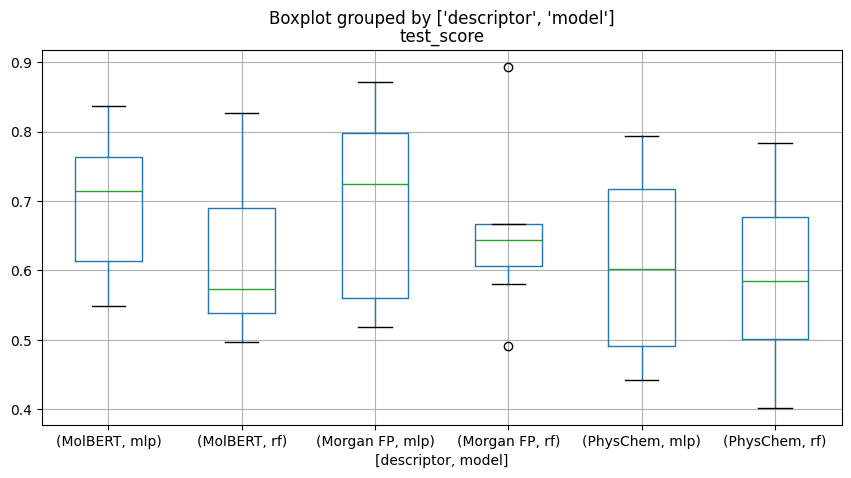

In [19]:
results_df = evaluate(data["class"], fps, descriptors, embeddings, folds=cv_folds)
results_df.boxplot('test_score', by=["descriptor", "model"], figsize=(10, 5))

MLPClassifier, MolBERT: 0.837, 0.836
RandomForestClassifier, Morgan FP: 0.829, 0.762
Pipeline, PhysChem: 0.634, 0.730


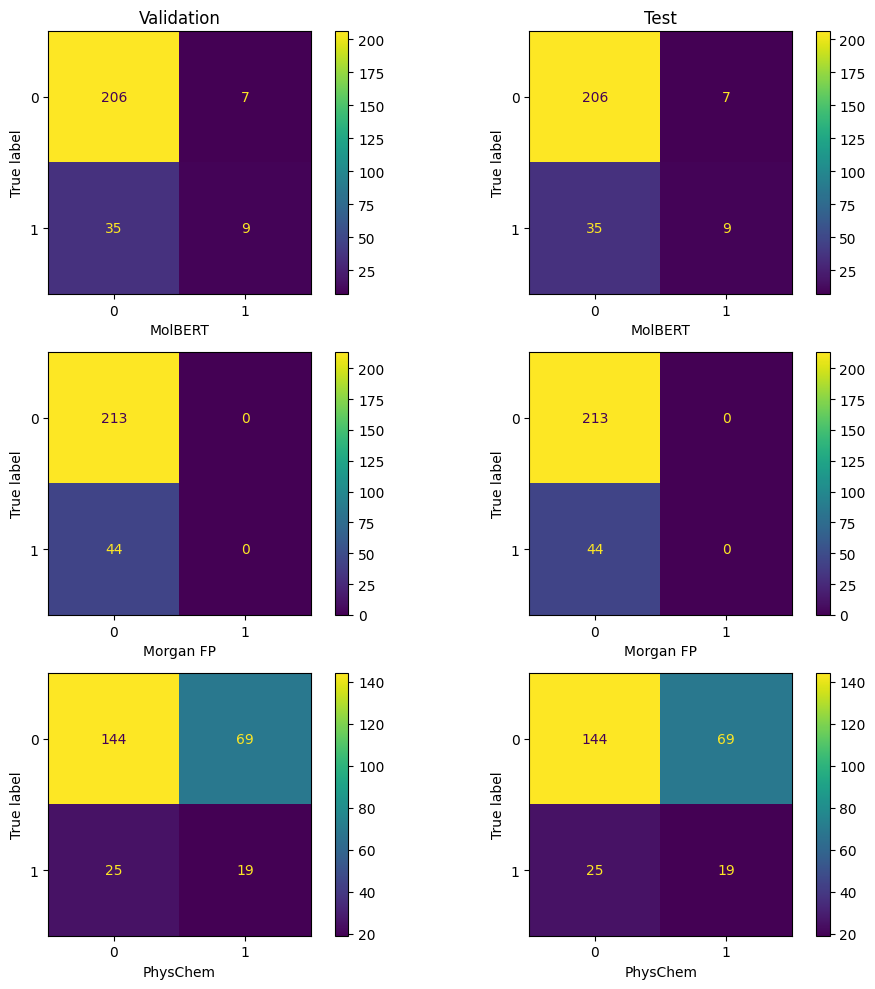

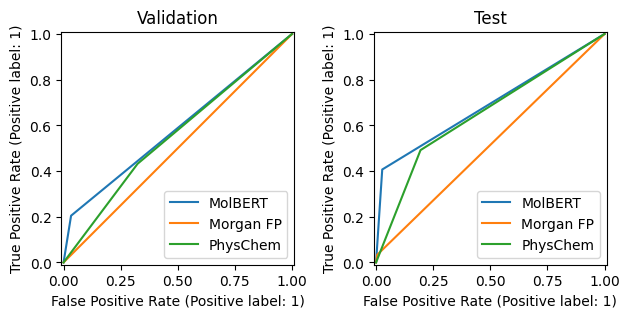

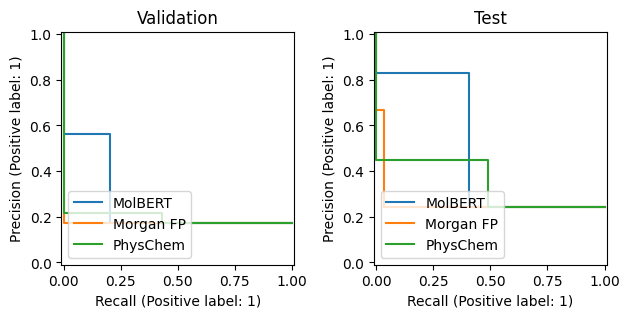

In [20]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay
best_classifiers = results_df.loc[results_df.groupby("descriptor")["test_score"].idxmax()]

cm_fig, cm_ax = plt.subplots(3, 2, figsize=(10, 10))
cm_ax[0, 0].set_title('Validation')
cm_ax[0, 1].set_title('Test')

roc_fig, roc_ax = plt.subplots(1, 2)
roc_ax[0].set_title('Validation')
roc_ax[1].set_title('Test')

pr_fig, pr_ax = plt.subplots(1, 2)
pr_ax[0].set_title('Validation')
pr_ax[1].set_title('Test')

for i, (_, (clf, input_type)) in enumerate(best_classifiers[["estimator", "descriptor"]].iterrows()):
    if input_type == "MolBERT":
        inputs = embeddings
    elif input_type == "Morgan FP":
        inputs = fps
    elif input_type == "PhysChem":
        inputs = descriptors
    else:
        raise ValueError(f"Unrecognized input type {input_type}")
    
    val_preds = clf.predict(inputs[validation_fold.index])
    val_true = data['class'][validation_fold.index]
    test_preds = clf.predict(inputs[test_fold.index])
    test_true = data['class'][test_fold.index]

    ConfusionMatrixDisplay.from_predictions(val_true, val_preds, ax=cm_ax[i, 0])
    ConfusionMatrixDisplay.from_predictions(val_true, val_preds, ax=cm_ax[i, 1])
    cm_ax[i, 0].set_xlabel(input_type)
    cm_ax[i, 1].set_xlabel(input_type)
    
    RocCurveDisplay.from_predictions(val_true, val_preds, ax=roc_ax[0], label=input_type)
    RocCurveDisplay.from_predictions(test_true, test_preds, ax=roc_ax[1], label=input_type)
    
    PrecisionRecallDisplay.from_predictions(val_true, val_preds, ax=pr_ax[0], label=input_type)
    PrecisionRecallDisplay.from_predictions(test_true, test_preds, ax=pr_ax[1], label=input_type)
    
    val_score = clf.score(inputs[validation_fold.index], data['class'][validation_fold.index])
    test_score = clf.score(inputs[test_fold.index], data['class'][test_fold.index])
    print(f"{clf.__class__.__name__}, {input_type}: {val_score:.3f}, {test_score:.3f}")
    
cm_fig.tight_layout()
roc_fig.tight_layout()
pr_fig.tight_layout()

In [21]:
MODEL_PARAMS[("mlp", "MolBERT")]

{'alpha': 0.0001, 'hidden_layer_sizes': (100, 100)}

In [27]:
molbert_clf = best_classifiers.query("descriptor == 'MolBERT'")["estimator"].iloc[0]

In [43]:
val_preds = molbert_clf.predict_proba(embeddings[validation_fold_mask])[:, 1].tolist()
test_preds =  molbert_clf.predict_proba(embeddings[test_fold_mask])[:, 1].tolist()
predictions = pd.DataFrame({
    "ID": validation_fold["ID"].tolist() + test_fold["ID"].tolist(),
    "cls_prb": val_preds + test_preds,
    "pKi": np.nan,
    "pIC50": np.nan
})

In [44]:
predictions.to_csv("molbert_classification_predictions.csv", index=False)

In [45]:
with open("molbert_classifier.pkl", "wb") as f:
    pickle.dump(molbert_clf, f)